# CELL 1 - Initialization

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import optuna
import random
import kagglehub # Import for the new download method
from PIL import Image, ImageStat

# --- Constants and Setup ---

IMAGE_SIZE = 100 
BATCH_SIZE = 64
RANDOM_SEED = 42
NUM_EPOCHS_TUNE = 5 # Fewer epochs for quick HPO search
NUM_EPOCHS_FINAL = 50 # Max epochs for final training (with Early Stopping)

# Set random seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Determine device (CUDA for GPU training)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


# --- Kaggle Download and DATA_DIR Setup ---
DATASET_ID = "utkarshsaxenadn/fruits-classification"

print(f"\nDownloading Kaggle dataset ID: {DATASET_ID} using kagglehub...")
print("NOTE: This requires your Kaggle API key (kaggle.json) to be set up in ~/.kaggle/.")

try:
    # Use kagglehub to download the dataset
    path = kagglehub.dataset_download(DATASET_ID)
    
    # kagglehub returns the path to the root of the extracted dataset files
    DATA_DIR = str(path)
    
    print("Download complete.")
    print(f"Path to dataset files: {DATA_DIR}")
    
except Exception as e:
    print(f"Kaggle Download Failed. Error: {e}")
    print("Please ensure your Kaggle API key is correctly configured and the kernel is switched.")
    # Fallback path if the download fails for manual placement
    DATA_DIR = './fruits-classification' 
    print(f"Falling back to assumed manual data path: {DATA_DIR}")

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3060

NOTE: This requires your Kaggle API key (kaggle.json) to be set up in ~/.kaggle/.
Download complete.
Path to dataset files: C:\Users\Bence\.cache\kagglehub\datasets\utkarshsaxenadn\fruits-classification\versions\1


# CELL 2 - Preprocessing

In [2]:
# --- Data Transforms, Normalization, and Features (Data Augmentation) ---

# --- FILTERING LOGIC ---
def filter_bad_images(path):
    """
    Returns True if the image is valid, False if it is an outlier or corrupt.
    """
    try:
        # 1. Check if file exists and is not empty (Missing Value check)
        if os.path.getsize(path) == 0:
            return False

        # 2. Check if image can be opened (Corruption check)
        # We open strictly to check headers, not to load data yet
        with Image.open(path) as img:
            img.verify()

        # 3. Check for Outliers (e.g., solid colors or extremely small images)
        # Note: We must re-open because verify() consumes the file handler
        with Image.open(path) as img:
            # A. Size Outlier: Remove images smaller than 10x10
            if img.width < 10 or img.height < 10:
                return False

            # B. Statistical Outlier: Remove solid color images (std dev ~ 0)
            stat = ImageStat.Stat(img)
            if sum(stat.stddev) < 5: # Threshold for "too flat/boring"
                return False

        return True

    except (IOError, SyntaxError) as e:
        print(f"Skipping corrupt image: {path}")
        return False

# 1. PIL Image Transforms (Augmentation applied before Tensor conversion)
pil_transforms = [
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
]

# 2. Tensor Conversion
tensor_conversion = [
    transforms.ToTensor(),
]

# 3. Tensor Transforms (Augmentation and Normalization applied after Tensor conversion)
tensor_transforms = [
    # FIX: RandomErasing MUST be after ToTensor()
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

# Training Transforms (All steps)
train_transforms = transforms.Compose(pil_transforms + tensor_conversion + tensor_transforms)

# Validation/Test Transforms (Only resize, ToTensor, Normalization)
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Adatfolyam (ImageFolder és DataLoader) ---
TRAIN_DIR = DATA_DIR + '\\Fruits Classification\\train'
TEST_DIR = DATA_DIR + '\\Fruits Classification\\test'

train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms, is_valid_file=filter_bad_images)
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms, is_valid_file=filter_bad_images)

# Split training data into training and validation sets (80/20 split)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Create DataLoaders (Data Streaming)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

CLASS_NAMES = train_data.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of Classes: {NUM_CLASSES}")

Number of Classes: 5


# CELL 3 - CNN Model Buildup

In [3]:
class FruitCNN(nn.Module):
    def __init__(self, num_conv_layers, filters, dense_units, dropout_rate, num_classes):
        super(FruitCNN, self).__init__()

        layers = []
        in_channels = 3
        current_img_size = IMAGE_SIZE

        # --- Create 'num_conv_layers' ---
        for i in range(num_conv_layers):
            out_channels = filters * (2**i)
            if out_channels > 512: out_channels = 512

            # --- THE FIX: Add BatchNorm2d ---
            # Order: Conv2d -> BatchNorm -> Activation
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # <--- Critical addition
                nn.LeakyReLU(0.1)             # <--- Changed to LeakyReLU to prevent "dead neurons"
            ]

            # Conditional Pooling
            if current_img_size > 4:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                current_img_size //= 2

            in_channels = out_channels

        self.features = nn.Sequential(*layers)

        # Calculate flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE)
            feature_map = self.features(dummy)
            flattened_size = feature_map.view(1, -1).size(1)

        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, dense_units),
            nn.BatchNorm1d(dense_units),      # <--- Optional: Helps the dense layer too
            nn.LeakyReLU(0.1),                # <--- Match activation style
            nn.Dropout(dropout_rate),
            nn.Linear(dense_units, num_classes)
            # No Softmax here! (See note below)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# CELL 4 - Hyperparameter optimization

In [4]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

# --- Trainer Function for Optuna (One Epoch) ---
def train_one_epoch_optuna(model, train_loader, optimizer, criterion, device):
    """Trains the model for one epoch."""
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# --- Evaluator Function for Optuna ---
def evaluate_model_optuna(model, val_loader, device):
    """Evaluates the model on validation data."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# --- Optuna Objective Function (VERBOSE VERSION) ---
def objective(trial):
    # --- 1. Search Space ---
    hp_filters = trial.suggest_categorical('filters', [32, 64])
    hp_dense_units = trial.suggest_categorical('dense_units', [256, 512])
    hp_dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    hp_weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    hp_learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.01, log=True)
    hp_optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # VERBOSE: Print start of trial
    print(f"\n=== [Trial {trial.number}] STARTING ===")
    print(f"Params: {trial.params}")

    # --- 2. Model Setup ---
    model = FruitCNN(
        num_conv_layers=7,
        filters=hp_filters,
        dense_units=hp_dense_units,
        dropout_rate=hp_dropout_rate,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    # --- 3. Optimizer Logic ---
    if hp_optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=hp_learning_rate, weight_decay=hp_weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=hp_learning_rate, momentum=0.9, weight_decay=hp_weight_decay)

    # --- 4. Scheduler ---
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # --- 5. Training Loop ---
    EPOCHS = 10
    for epoch in range(EPOCHS):

        # Train (Using helper function to get loss easily)
        train_loss = train_one_epoch_optuna(model, train_loader, optimizer, criterion, DEVICE)

        # Step the scheduler
        scheduler.step()

        # Evaluate
        accuracy = evaluate_model_optuna(model, val_loader, DEVICE)

        # VERBOSE: Print progress
        print(f"[Trial {trial.number}] Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Acc: {accuracy:.4f}")

        # Optuna Pruning Logic
        trial.report(accuracy, epoch)
        if trial.should_prune():
            print(f"!!! [Trial {trial.number}] PRUNED at Epoch {epoch+1} (Acc: {accuracy:.4f}) !!!")
            raise optuna.exceptions.TrialPruned()

    print(f"=== [Trial {trial.number}] FINISHED | Final Acc: {accuracy:.4f} ===")
    return accuracy

# --- Run Optuna Search ---
# Optional: Turn off standard Optuna logging so it doesn't clash with your custom prints
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Starting Hyperparameter Optimization (HPO) with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("\n--- Best Trial Results ---")
best_trial = study.best_trial
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

best_hps = best_trial.params

Starting Hyperparameter Optimization (HPO) with Optuna...

=== [Trial 0] STARTING ===
Params: {'filters': 32, 'dense_units': 256, 'dropout_rate': 0.43227430273153333, 'weight_decay': 1.5512829518845283e-05, 'learning_rate': 0.0011839687482698518, 'optimizer': 'SGD'}
[Trial 0] Epoch 1/10 | Train Loss: 1.4385 | Val Acc: 0.4552
[Trial 0] Epoch 2/10 | Train Loss: 1.2845 | Val Acc: 0.4959
[Trial 0] Epoch 3/10 | Train Loss: 1.1997 | Val Acc: 0.5392
[Trial 0] Epoch 4/10 | Train Loss: 1.1373 | Val Acc: 0.5675
[Trial 0] Epoch 5/10 | Train Loss: 1.1037 | Val Acc: 0.5603
[Trial 0] Epoch 6/10 | Train Loss: 1.0961 | Val Acc: 0.5825
[Trial 0] Epoch 7/10 | Train Loss: 1.0986 | Val Acc: 0.5840
[Trial 0] Epoch 8/10 | Train Loss: 1.0842 | Val Acc: 0.5649
[Trial 0] Epoch 9/10 | Train Loss: 1.0865 | Val Acc: 0.5809
[Trial 0] Epoch 10/10 | Train Loss: 1.0939 | Val Acc: 0.5881
=== [Trial 0] FINISHED | Final Acc: 0.5881 ===

=== [Trial 1] STARTING ===
Params: {'filters': 64, 'dense_units': 256, 'dropout_rate

# CELL 5 - Training, Testing, Validation and Final Evaluation

In [5]:
# --- Final Model Initialization ---
final_model = FruitCNN(
    num_conv_layers=7,
    filters=best_hps['filters'],
    dense_units=best_hps['dense_units'],
    dropout_rate=best_hps['dropout_rate'],
    num_classes=NUM_CLASSES
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=1e-2) #best_hps['learning_rate']

# --- Custom Early Stopping Logic (Low-Level Logic) ---
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=10):
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    print("Starting Final Training with Early Stopping...")
    
    for epoch in range(1, epochs + 1):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            # FIX: labels already contains the class indices
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # FIX: labels already contains the class indices
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total
        
        # Log History
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch {epoch}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early Stopping Logic 
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best weights
            best_model_weights = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping at epoch {epoch}. Validation loss did not improve for {patience} epochs.")
                # Restore best weights
                model.load_state_dict(best_model_weights)
                break

    return model, history

# --- Run Final Training ---
final_model, history = train_and_validate(
    final_model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    NUM_EPOCHS_FINAL, 
    DEVICE
)

Starting Final Training with Early Stopping...
Epoch 1/50: Train Loss: 1.7725, Val Loss: 1.6986, Val Acc: 0.2923
Epoch 2/50: Train Loss: 1.5565, Val Loss: 1.3631, Val Acc: 0.4124
Epoch 3/50: Train Loss: 1.3874, Val Loss: 1.5307, Val Acc: 0.4067
Epoch 4/50: Train Loss: 1.3274, Val Loss: 1.4162, Val Acc: 0.4211
Epoch 5/50: Train Loss: 1.2521, Val Loss: 1.2152, Val Acc: 0.4969
Epoch 6/50: Train Loss: 1.2215, Val Loss: 1.2956, Val Acc: 0.4464
Epoch 7/50: Train Loss: 1.1825, Val Loss: 1.1371, Val Acc: 0.5351
Epoch 8/50: Train Loss: 1.1321, Val Loss: 1.1988, Val Acc: 0.5139
Epoch 9/50: Train Loss: 1.1217, Val Loss: 1.2812, Val Acc: 0.5108
Epoch 10/50: Train Loss: 1.0905, Val Loss: 1.1835, Val Acc: 0.5144
Epoch 11/50: Train Loss: 1.0756, Val Loss: 1.1451, Val Acc: 0.5505
Epoch 12/50: Train Loss: 1.0364, Val Loss: 1.1641, Val Acc: 0.5505
Epoch 13/50: Train Loss: 1.0065, Val Loss: 1.0808, Val Acc: 0.5557
Epoch 14/50: Train Loss: 0.9886, Val Loss: 1.0581, Val Acc: 0.5892
Epoch 15/50: Train Loss:

# CELL 6 - Visualization


--- Training History Visualization ---


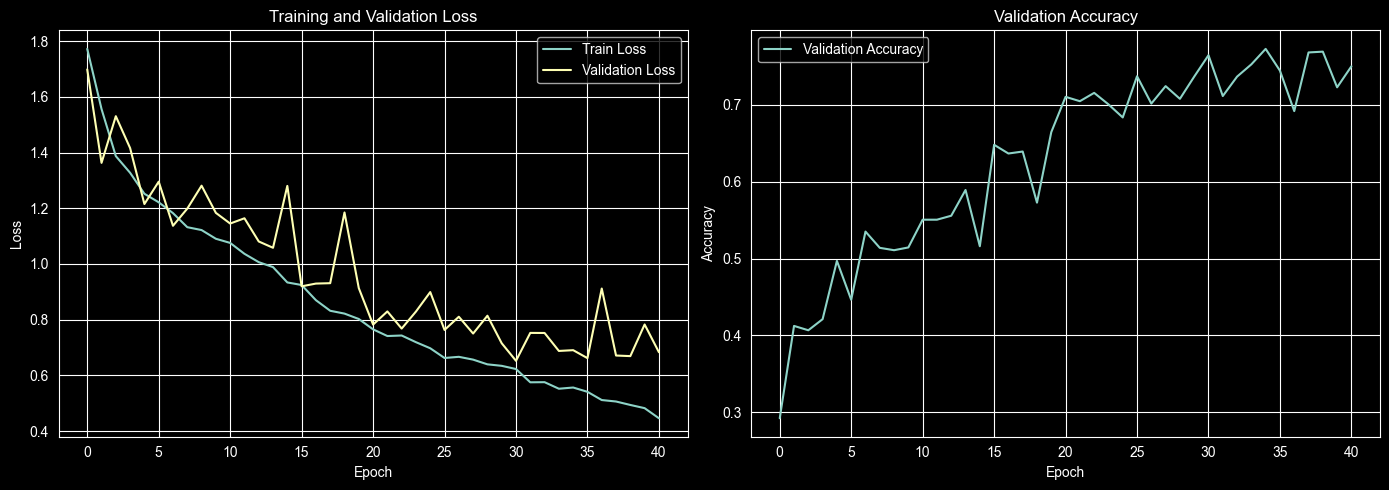


Overall Test Accuracy Score: 81.00%

--- Classification Report ---
              precision    recall  f1-score   support

       Apple     0.7500    0.6000    0.6667        20
      Banana     0.7727    0.8500    0.8095        20
       Grape     1.0000    0.9000    0.9474        20
       Mango     0.7143    0.7500    0.7317        20
  Strawberry     0.8261    0.9500    0.8837        20

    accuracy                         0.8100       100
   macro avg     0.8126    0.8100    0.8078       100
weighted avg     0.8126    0.8100    0.8078       100


--- Confusion Matrix ---


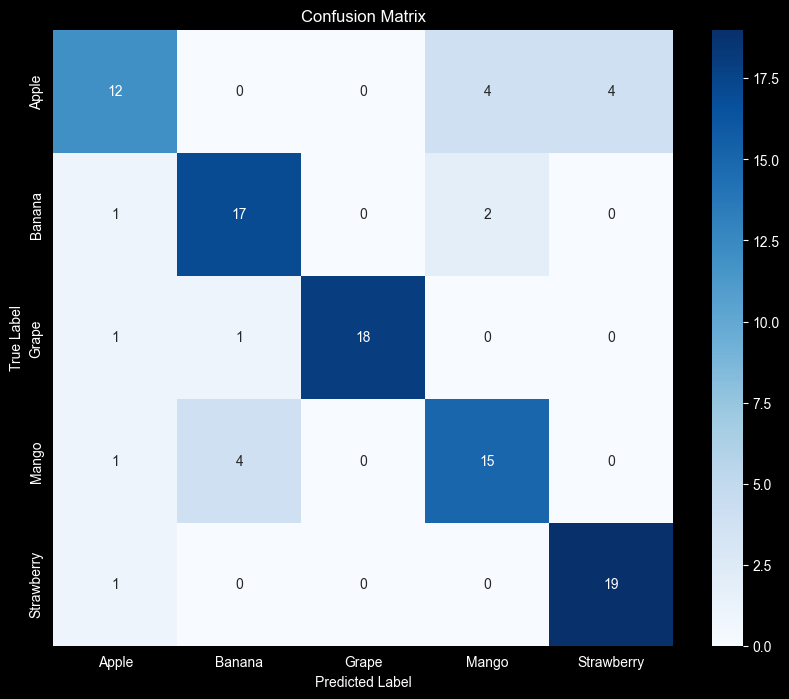

In [6]:
# --- Plot Training History ---
# Plot Training History (Visualization)
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Validation Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot Accuracy
    ax[1].plot(history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# --- Model Evaluation on Test Set ---
def evaluate_test(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # FIXED: Removed .argmax(dim=1) because labels are already indices
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Overall Accuracy Score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Test Accuracy Score: {overall_accuracy*100:.2f}%")

    # Classification Report (F-Score, Recall, Precision)
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion Matrix (Visualization)
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return overall_accuracy

print("\n--- Training History Visualization ---")
plot_history(history)

# --- Run Test Evaluation ---
# Ensure your class_names list matches the number of classes in the model
test_accuracy = evaluate_test(final_model, test_loader, DEVICE, CLASS_NAMES)